In [ ]:
!pip install python-terrier

### Imports

In [3]:
import pandas as pd
# Helpful for showing indexing information
pd.set_option('display.max_colwidth', 150)

import pyterrier as pt
import os

if not pt.started():
    pt.init()

### Preparing dataset

In [31]:
df = pd.read_json('./new_second_filtered_dataset_withtopics_650.json',lines=False )

for i in range(0, len(df['field'])):
    df['field'][i] = ', '.join(df['field'][i])


d2qresult = pd.read_csv('./d2qresult.csv' )
df['querygen'] = d2qresult['querygen']

df = df.rename(columns={'abstract':'text'})
df = df.rename(columns={'title':'docno'})
#concate 
df['text'] = "title: " + df["docno"]+ " abstract: "+df['text'] + " fields: "+df['field'] + "querygen: "+df['querygen']
df = df.reset_index(drop=True)
df = df.astype(str)
print(df['text'][0])
df

<ipython-input-31-362e7e488653>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['field'][i] = ', '.join(df['field'][i])


In [ ]:
#@title load index if exist
index_dir = './papers_index2'
index_ref = pt.IndexRef.of(index_dir + "/data.properties")
index = pt.IndexFactory.of(index_ref)

### Indexing

In [ ]:
import os

index_dir = './papers_index2'
os.mkdir(index_dir)
indexer = pt.DFIndexer(index_dir, overwrite=True)
docs_df = df
index_ref = indexer.index(df["text"], df)
index = pt.IndexFactory.of(index_ref)

In [8]:
print(index.getCollectionStatistics().toString())

Number of documents: 38252
Number of terms: 39962
Number of postings: 2820169
Number of fields: 0
Number of tokens: 4656384
Field names: []
Positions:   false



### train the model for the IR system

In [9]:
bm = pt.BatchRetrieve(index, wmodel="BM25")
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")

In [10]:
#@title load text topics
# load test topics
test_queries = ['immigration problem',

'computer-assisted mediation',

'collective intelligence  crowdsourcing',

'social behaviour',

'employment proverty income',

'computational social ontology',

'gender discrimination',

'suicide',

'infectious diseases',

'structural hole']

qidlst = ['10', '11', '12', '13', '14', '15', '16', '17', '18', '19']

test_topics = pd.DataFrame(list(zip( qidlst,test_queries)), columns =['qid', 'query'])

In [11]:
#@title load train topics
#train_topic
train_queries = [
'human-centric computing',
'ethnographic',
'social governance',
'social economics',
'political issues',
'social network analysis',
'education',
'community neighborhood',
'population structure',
'criminal',
]

qidlst = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

train_topics = pd.DataFrame(list(zip( qidlst,train_queries)), columns =['qid', 'query'])

In [ ]:
#@title load qrels
#qrels
dfall = pd.read_csv ('./qrelsfinal.csv')
dfall['qid']=dfall['qid'].apply(str)
dfall['label']=dfall['label'].apply(int)
qrels = dfall
qrels

In [13]:
#@title define features
ltr_feats1 = bm >> pt.text.get_text(index, ["docno", "date", "field", "author", "topic", "querygen", "country"]) >> (
    pt.transformer.IdentityTransformer() #feature1: BM25 score
    ** 
    tfidf #feature2:tfidf score
    ** 
    pt.BatchRetrieve(index, wmodel="CoordinateMatch") #feature3: CoordinateMatch
    **
    (pt.apply.doc_score(lambda row: int(int(row["date"]) >= 2000))) #feartue4: was the publication later than 2020?
    # **
    # (pt.apply.doc_score(lambda row: int(len(row["field"]) >= 2)))
    **
    (pt.batchretrieve.TextScorer(body_attr="author",  wmodel='BM25') ) #feature5: score of authors
    # **
    # (pt.batchretrieve.TextScorer(body_attr="topic", wmodel='BM25') ) 
    **
    (pt.batchretrieve.TextScorer(body_attr="querygen", wmodel='BM25') ) #feature6: score of doc2query result
    )

In [ ]:
!pip install fastrank

In [14]:
#@title train model
import fastrank
train_request = fastrank.TrainRequest.coordinate_ascent()

params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567

ca_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(train_request, form='fastrank')

%time ca_pipe.fit(train_topics, qrels)

19:40:54.662 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
19:40:59.448 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.8/dist-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7fdceb4712b0>, expected 8555 received 8653, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any "
/usr/local/lib/python3.8/dist-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7fdceb471f70>, expected 8555 received 8653, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any "


CPU times: user 32min 12s, sys: 8.85 s, total: 32min 20s
Wall time: 18min 14s


In [20]:
#@title evaluate the model with baseline and naive system
from pyterrier.measures import *

naiveresult = pd.read_csv ('./naiveresult.csv')
naiveresult['qid']=naiveresult['qid'].apply(str)

bm25 = pt.BatchRetrieve(index, wmodel="BM25")
pt.Experiment(
    [ ca_pipe, bm25, naiveresult], 
    test_topics,
    qrels,
    eval_metrics=["map", "ndcg", nDCG@10],
    names=["ca_pipe", "baseline", "naive"]
)

20:21:40.009 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:21:44.343 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.8/dist-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7fdceb4712b0>, expected 8289 received 8409, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any "
/usr/local/lib/python3.8/dist-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7fdceb471f70>, expected 8289 received 8409, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any "


,name,map,ndcg,nDCG@10
0,ca_pipe,0.483749,0.606593,0.480346
1,baseline,0.480392,0.602020,0.458352
2,naive,0.003027,0.014190,0.046375


### (After training the model) User start to use the IR system here

In [34]:
#@title load function of topic graph construction

import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pylab as plt
from matplotlib import font_manager as fm
from  matplotlib import cm
import numpy as np
import json


def get_topic_graph_by_fields(resultdict):

  fig, ax = plt.subplots(figsize=(15, 10))

  topic1 = {'social network': '203', 'social network analysis': '53', 'data mining': '41', 'human-computer interaction': '38', 'semantic web': '28', 'machine learning': '19', 'world wide web': '17', 'social networking sites': '17', 'artificial intelligence': '15', 'online social networks': '14', 'information systems': '13', 'computer science': '12', 'online social networking': '11', 'collective intelligence': '10', 'social networks': '2123', 'online social networks': '967', 'social media': '771', 'social networking sites': '392', 'social networking services': '213', 'social network analysis': '186', 'mobile social networks': '159', 'social web': '64', 'data mining': '63', 'human-computer interaction': '60', 'social media sites': '57', 'recommender systems': '54', 'social network data': '54', 'machine learning': '53', 'online social media': '51', 'location-based social networks': '50', 'social media platforms': '50', 'mobile devices': '49', 'social computing': '44', 'social media data': '43', 'world wide web': '40', 'collective intelligence': '39', 'sina weibo': '36', 'social media services': '35', 'natural language processing': '32', 'semantic web': '32', 'social networking applications': '31', 'twitter users': '27', 'community detection': '26', 'amazon mechanical turk': '25', 'computer science': '25', 'influence maximization': '25', 'social capital': '25', 'social interactions': '24', 'big data': '24', 'social networks': '2884', 'social media': '2487', 'online social networks': '1359', 'social media platforms': '346', 'machine learning': '307', 'social networking sites': '301', 'mobile social networks': '251', 'artificial intelligence': '240', 'social network analysis': '226', 'social networking services': '211', 'social media data': '178', 'big data': '158', 'online social media': '153', 'natural language processing': '153', 'human-computer interaction': '151', 'location-based social networks': '145', 'sentiment analysis': '127', 'influence maximization': '125', 'data mining': '111', 'mobile devices': '103', 'social media users': '90', 'community detection': '89', 'spatial crowdsourcing': '88', 'emotion recognition': '85', 'fake news': '84', 'recommender systems': '83', 'social internet': '69', 'social media sites': '69', 'covid-19 pandemic': '67', 'twitter users': '67', 'support vector machine': '66', 'twitter data': '60', 'deep learning': '57', 'mobile crowdsourcing': '54'}


  # nodelist1 = list(set(list(topic1.keys())))
  
  nodelist2 = []


  # 创建空的网格
  G=nx.Graph()
  # 添加节点

  
  for i in range(0,len(resultsdict)-1):
      # print(i)
      article =resultsdict[i]
      topic = ((article['topic'])[1:len(article['topic'])-1]).split(', ')
      date = article['date']
      # print('topic:')
      # print((topic))
      
#        if not (int(date) >=1994 and int(date) <2022):
#            print('invalid year:'+date)
#            continue
      
      if len(topic) != 0:
          cp = ['','']
          for j in topic:
              if j not in G.nodes():
                G.add_node(j)
              cp[0] = j
              for k in topic:
                  if k != j:
                      cp[1] = k
                      if G.has_edge(cp[0],cp[1]):
                          G[cp[0]][cp[1]]['weight']+=1
                      else:
                          G.add_edge(cp[0],cp[1],weight = 1)


      # print(cp)
      nodedegrees = {}

      for n in G.nodes():
          if n not in nodedegrees.keys():
              nodedegrees.setdefault(n, 0)
          nodedegrees[n] = G.degree(n)
      
      # print('degree')
      # print(sorted(nodedegrees.items(), key=lambda x: x[1], reverse=True))



  node_label = nx.get_node_attributes(G, 'desc')


  nodelist1 = G.nodes()

  #分成两组点，分别画图
  sizes1 = []
  sizes2 = []

#节点大小根据effective size来调整
  for v in G.nodes():
      if v in nodelist1:
          sizes1.append(600*(G.degree(v)))
      # elif v in nodelist2:
      #     sizes2.append(250*(nx.effective_size(G)[v]))

  # print(sizes1)
  # print(sizes2)

  pos = nx.random_layout(G)
 
  nx.draw_networkx_nodes(G,pos,nodelist=nodelist1,label=node_label.items(),node_size=sizes1,node_color = 'sandybrown',edgecolors='gray')


  for e in G.edges():
      ewidth = G[e[0]][e[1]]['weight']
      # print(e)
      # print(ewidth)
      if (e[0] in nodelist1 and e[1] in nodelist1) or (e[0] in nodelist2 and e[1] in nodelist2):
          nx.draw_networkx_edges(G,pos,edgelist=[e],width=ewidth/2,edge_color='tan')

          
  nx.draw_networkx_labels(G, pos,font_size=15,font_family='sans-serif')



  nodedegrees = {}

  for n in G.nodes():
      if n != "''":
          nodedegrees.setdefault(n, 0)
      nodedegrees[n] = G.degree(n)
      



  # nx.draw(G,pos=nx.circular_layout(G),with_labels=True)
  print('topic degrees:')
  print(nodedegrees)
  plt.show()
  return G


In [38]:
#@title load function of country graph construction

import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pylab as plt
from matplotlib import font_manager as fm
from  matplotlib import cm
import numpy as np
import json


def get_country_graph_by_fields(resultdict):

  fig, ax = plt.subplots(figsize=(15, 10))

  # topic1 = {'social network': '203', 'social network analysis': '53', 'data mining': '41', 'human-computer interaction': '38', 'semantic web': '28', 'machine learning': '19', 'world wide web': '17', 'social networking sites': '17', 'artificial intelligence': '15', 'online social networks': '14', 'information systems': '13', 'computer science': '12', 'online social networking': '11', 'collective intelligence': '10', 'social networks': '2123', 'online social networks': '967', 'social media': '771', 'social networking sites': '392', 'social networking services': '213', 'social network analysis': '186', 'mobile social networks': '159', 'social web': '64', 'data mining': '63', 'human-computer interaction': '60', 'social media sites': '57', 'recommender systems': '54', 'social network data': '54', 'machine learning': '53', 'online social media': '51', 'location-based social networks': '50', 'social media platforms': '50', 'mobile devices': '49', 'social computing': '44', 'social media data': '43', 'world wide web': '40', 'collective intelligence': '39', 'sina weibo': '36', 'social media services': '35', 'natural language processing': '32', 'semantic web': '32', 'social networking applications': '31', 'twitter users': '27', 'community detection': '26', 'amazon mechanical turk': '25', 'computer science': '25', 'influence maximization': '25', 'social capital': '25', 'social interactions': '24', 'big data': '24', 'social networks': '2884', 'social media': '2487', 'online social networks': '1359', 'social media platforms': '346', 'machine learning': '307', 'social networking sites': '301', 'mobile social networks': '251', 'artificial intelligence': '240', 'social network analysis': '226', 'social networking services': '211', 'social media data': '178', 'big data': '158', 'online social media': '153', 'natural language processing': '153', 'human-computer interaction': '151', 'location-based social networks': '145', 'sentiment analysis': '127', 'influence maximization': '125', 'data mining': '111', 'mobile devices': '103', 'social media users': '90', 'community detection': '89', 'spatial crowdsourcing': '88', 'emotion recognition': '85', 'fake news': '84', 'recommender systems': '83', 'social internet': '69', 'social media sites': '69', 'covid-19 pandemic': '67', 'twitter users': '67', 'support vector machine': '66', 'twitter data': '60', 'deep learning': '57', 'mobile crowdsourcing': '54'}


  # nodelist1 = list(set(list(topic1.keys())))
  
  nodelist2 = []


  # 创建空的网格
  G=nx.Graph()
  # 添加节点

  
  for i in range(0,len(resultsdict)-1):
      # print(i)
      article =resultsdict[i]
      topic = ((article['country'])[1:len(article['country'])-1]).split(', ')
      date = article['date']
      # print('country:')
      # print((topic))
      
#        if not (int(date) >=1994 and int(date) <2022):
#            print('invalid year:'+date)
#            continue
      
      if len(topic) != 0:
          cp = ['','']
          for j in topic:
              if j not in G.nodes():
                G.add_node(j)
              cp[0] = j
              for k in topic:
                  if k != j:
                      cp[1] = k
                      if G.has_edge(cp[0],cp[1]):
                          G[cp[0]][cp[1]]['weight']+=1
                      else:
                          G.add_edge(cp[0],cp[1],weight = 1)


      # print(cp)
      nodedegrees = {}

      for n in G.nodes():
          if n not in nodedegrees.keys():
              nodedegrees.setdefault(n, 0)
          nodedegrees[n] = G.degree(n)
      
      # print('degree')
      # print(sorted(nodedegrees.items(), key=lambda x: x[1], reverse=True))



  node_label = nx.get_node_attributes(G, 'desc')


  nodelist1 = G.nodes()

  #分成两组点，分别画图
  sizes1 = []
  sizes2 = []

#节点大小根据effective size来调整
  for v in G.nodes():
      if v in nodelist1:
          sizes1.append(600*(G.degree(v)))
      # elif v in nodelist2:
      #     sizes2.append(250*(nx.effective_size(G)[v]))

  # print(sizes1)
  # print(sizes2)

  pos = nx.random_layout(G)
#    #pos = dict()
#    pos.update( (n, (1, i)) for i, n in enumerate(nodelist1) )
#    pos.update( (n, (2, i)) for i, n in enumerate(nodelist2) )

##自定义位置
#    pos = {'AI': ([-1,0.04]), 'Algorithms & Theory': ([-0.85,0.42]), 'Software & Application': ([-0.13,0.1]), 'Graph': ([-0.22,0.54]), 'Hardware': ([-0.527,0.736]), 'System & Architecture': ([-0.87,-0.33]), 'Networks': ([-0.402,-0.418]), 'Policy': ([0.3,-0.4]), 'Psychology': ([1.35,0.3]),'Social Issue': ([0.422,0.818]), 'Education': ([0.776,0.893]), 'Health': ([1.06,0.68]), 'Business': ([0.205,0.495]), 'Language & Arts': ([1.24,-0.31]), 'History & Theory': ([0.78,-0.666]), 'Religion': ([1.03,-0.5]), 'Urban & Rural development': ([0.19,0.009])}
  
  nx.draw_networkx_nodes(G,pos,nodelist=nodelist1,label=node_label.items(),node_size=sizes1,node_color = 'mediumpurple',edgecolors='gray')


  for e in G.edges():
      ewidth = G[e[0]][e[1]]['weight']
      # print(e)
      # print(ewidth)
      if (e[0] in nodelist1 and e[1] in nodelist1) or (e[0] in nodelist2 and e[1] in nodelist2):
          nx.draw_networkx_edges(G,pos,edgelist=[e],width=ewidth, edge_color='grey')

          
  nx.draw_networkx_labels(G, pos,font_size=15,font_family='sans-serif')


  # print('nodes:')
  # print(G.nodes())
  # for n in G.nodes():
  #     print((n))
  #     print(G.degree(n))


  nodedegrees = {}

  for n in G.nodes():
      if n != '':
          nodedegrees.setdefault(n, 0)
      nodedegrees[n] = G.degree(n)
      



  print('country degrees:')
  print(nodedegrees)
  plt.show()
  return G


In [42]:
#@title User type in query here
query = 'female concern'
SCretrievalpipeline = ca_pipe%100
results = SCretrievalpipeline.transform(query)
results

/usr/local/lib/python3.8/dist-packages/pyterrier/ops.py:331: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  topics = m.transform(topics)


21:04:04.248 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:04:04.759 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.8/dist-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7fdceb4712b0>, expected 1000 received 1014, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any "
/usr/local/lib/python3.8/dist-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7fdceb471f70>, expected 1000 received 1014, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any "


,qid,docid,docno,score,query,date,field,author,topic,querygen,country,features,rank
0,1,12849,Gender differences in cooperation with group membership.,5.068610,female concern,2011,,"['GaryCharness', 'AldoRustichini']",[],which research is concerned with gender differences and comparing the behavior of people?\ndifference between male and female\nhow gender is assoc...,"['us', 'us']","[18.52227573696802, 10.204075089736989, 2.0, 1.0, 0.0, 8.52392609025015]",0
1,1,4473,Exploring indonesian young females online social networks (OSNs) addictions: a case study of mass communication female undergraduate students.,4.724664,female concern,2017,,"['Joice Yulinda Luke', 'Lidya Wati Evelina']","['online social networks', 'social networks', 'social network']",how do you get addicted to sex online\nwhat is osn\nwhat is osn,"['id', 'id']","[17.158127555516273, 9.439533038210886, 2.0, 1.0, 0.0, 0.0]",1
2,1,3550,Relations between personality traits and empathy for social pain and physical pain.,4.291764,female concern,2017,Graph,"['Aiko Murata', 'Katsumi Watanabe']",[],what type of person develops empathy?\nhow do personality traits affect empathy\nwhat traits are associated with empathy,"['jp', 'jp']","[15.846368175878332, 8.758686566186917, 2.0, 1.0, 0.0, 0.0]",2
3,1,22112,Facebook use and depressive symptomatology: Investigating the role of neuroticism and extraversion in youth.,3.829680,female concern,2014,,"['Teague E.Simoncic', 'Kate R.Kuhlman', 'IvanVargas', 'SeanHouchins', 'Nestor L.Lopez-Duran']","['social networking sites', 'social network']",why does facebook cause depressions in youth\nwhich of the following is a depressing effect of facebook?\neffects of facebook on youth,['us'],"[14.503795273577591, 8.001579397650836, 2.0, 1.0, 0.0, 0.0]",6
4,1,28793,Body image 2.0: Associations between social grooming on Facebook and body image concerns.,3.837952,female concern,2015,History & Theory,"['Ji WonKim', 'T. MakanaChock']",['social media'],does social media affect your body image\nis social media an association or problem with gender identity?\nwhat's the relationship between faceboo...,['us'],"[14.493135199377477, 8.03341355733673, 2.0, 1.0, 0.0, 0.0]",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1,35913,"The Relevance of Privacy Concerns, Trust, and Risk for Hybrid Social Media.",2.232103,female concern,2021,Software & Application,"['Borchert, Angela', 'Wainakh, Aidmar', 'Krämer, Nicole', 'Mühlhäuser, Max', 'Heisel, Maritta']","['social media', 'online social media']",why privacy concerns\nwhat is the relevance of privacy concerns\nwhat is the importance of privacy concerns,"['de', 'de', 'de', 'de', 'de']","[8.37800614058916, 4.7075613261795475, 1.0, 1.0, 0.0, 6.385898364399933]",99
97,1,2310,Relation between Carotid Intima-Media Thickness and diastolic augmentation index in Chinese population.,2.284626,female concern,2016,"AI, Area and Development studies","['Qingyuan Wu', 'Jun Ye', 'Jian Yang', 'Zuchang Ma', 'Yining Sun', 'Yongliang Zhang']",[],what is cimt\nwhich measure is used to measure atherosclerosis\ncortical thickness,"['cn', 'cn', 'cn', 'cn', 'cn', 'cn']","[8.373806064708, 4.581637490306553, 1.0, 1.0, 0.0, 0.0]",92
98,1,20040,Who Donates on Line? Segmentation Analysis and Marketing Strategies Based on Machine Learning for Online Charitable Donations in Taiwan.,2.276753,female concern,2021,"Graph, Education, Economics, Area and Development studies","['Chiung-Wen Hsu', 'Yu-Lin Chang', 'Tzer-Shyong Chen', 'Te-Yi Chang', 'Yu-Da Lin']",[],who donates on line\nwho donates online\nwho donates on line,"['cn', 'cn', 'cn', 'cn', 'cn']","[8.350572030372284, 4.5689252395162905, 1.0, 1.0, 0.0, 0.0]",93
99,1,26961,Noticing the other gender on Google+.,2.273577,female concern,2014,,"['Diego Couto de Las Casas', 'Gabriel Magno', 'Evandro Cunha', 'Marcos André Gonçalves', 'César Cambraia', 'Virgilio Almeida']","['online social networking', 'social media', 'social network']",google+ can you tell your gender\ncan i put my ge

<ipython-input-44-9595f97b9fa3>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  resultsdict= results.to_dict('record')


topic degrees:
{'': 0, "'online social networks'": 5, "'social networks'": 5, "'social network'": 13, "'social networking sites'": 4, "'social media'": 11, "'social network analysis'": 1, "'machine learning'": 9, "'computer science'": 1, "'data mining'": 1, "'human-computer interaction'": 1, "'deep learning'": 4, "'mobile devices'": 0, "'social media users'": 1, "'social media platforms'": 1, "'artificial intelligence'": 0, "'social media sites'": 1, "'online social media'": 2, "'twitter users'": 3, "'support vector machine'": 2, "'social networking services'": 3, "'online social networking'": 7, "'social networking applications'": 4, "'sina weibo'": 0, "'social interactions'": 3, "'natural language processing'": 1, "'social media services'": 1}


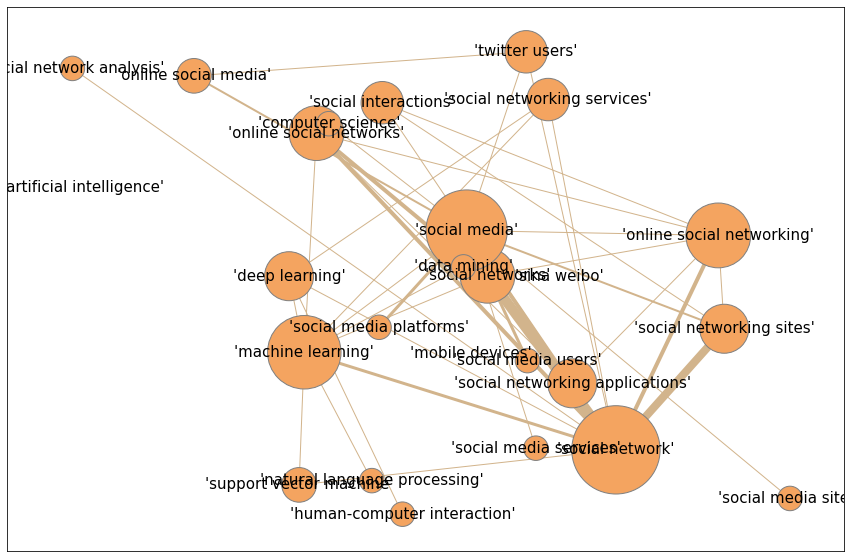

In [44]:
#@title generate topic graph
resultsdict= results.to_dict('record')
get_topic_graph_by_fields(resultsdict)

In [39]:
#@title topic search (filter)

topicquery = 'data mining' #type in topic to search(filter) (must use a term within above graph):
df_topicfilterresults = results[results['topic'].str.contains(topicquery)]
df_topicfilterresults

,qid,docid,docno,score,query,date,field,author,topic,querygen,country,features,rank
8,1,23791,Gender and Age Categorization Using Gaze Analysis.,3.568193,female concern,2014,"Graph, Area and Development studies","['Virginio Cantoni', 'Marco Porta', 'Chiara Galdi', 'Michele Nappi', 'Harry Wechsler']",['data mining'],gender age categorisation in gaze analysis\ngender age categorisation yahoo\nwhich of the following categories is used for gender age categorisation?,"['it', 'it', 'it', 'it', 'us']","[13.744200180598902, 7.573063069817334, 2.0, 1.0, 0.0, 0.0]",17
17,1,12325,"Gender Differences in End-User Debugging, Revisited: What the Miners Found.",3.670196,female concern,2006,,"['V. Grigoreanu', 'L. Beckwith', 'X. Fern', 'S. Yang', 'C. Komireddy', 'V. Narayanan', 'C. Cook', 'M. Burnett']",['data mining'],why gender differences in end user debugging\nwhat was the first time gender differences emerged during end-user debugging?\nwhat the miners found,"['us', 'us', 'us', 'us', 'us', 'us', 'us', 'us']","[12.462450302704383, 6.818694998036561, 1.0, 1.0, 0.0, 0.0]",13
84,1,12098,Machine Learning and Data Visualization to Evaluate a Robotics and Programming Project Targeted for Women.,2.379639,female concern,2021,"AI, Algorithms & Theory, Hardware, Area and Development studies","['Lima, Danielli A.', 'Ferreira, Maria Eugênia A.', 'Silva, Aline Fernanda F.']","['data mining', 'machine learning']",who is machine learning used for\nwhat project uses machine learning and data visualization\nwhy is it important to use machine learning for robotics,"['br', 'br', 'br']","[8.654176666861364, 4.7350392352334545, 1.0, 1.0, 0.0, 0.0]",83
89,1,3626,Finding Gender Differences in End-User Debugging: A Data Mining Approach.,2.329700,female concern,2007,,['Valentina Grigoreanu'],['data mining'],what gender is a user in end users\nfinding gender differences in end user debugging\nwhat are the gender differences in end user debugging,['us'],"[8.506812812146903, 4.654410694727674, 1.0, 1.0, 0.0, 0.0]",85


<ipython-input-40-8bdddf7d2afd>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  resultsdict= results.to_dict('record')


country degrees:
{"'us'": 12, "'id'": 1, "'jp'": 0, "'ca'": 1, "'au'": 1, "'it'": 1, "'cn'": 3, "'sa'": 1, "'in'": 0, "'de'": 2, "'nl'": 1, "'mx'": 0, "'th'": 0, "'es'": 2, '': 0, "'se'": 2, "'gb'": 2, "''": 0, "'gr'": 1, "'br'": 1, "'kr'": 0, "'lu'": 1, "'at'": 2, "'cz'": 1, "'kz'": 0, "'fr'": 2, "'ma'": 2, "'fi'": 0, "'ch'": 0, "'pt'": 0, "'pk'": 1, "'il'": 0}


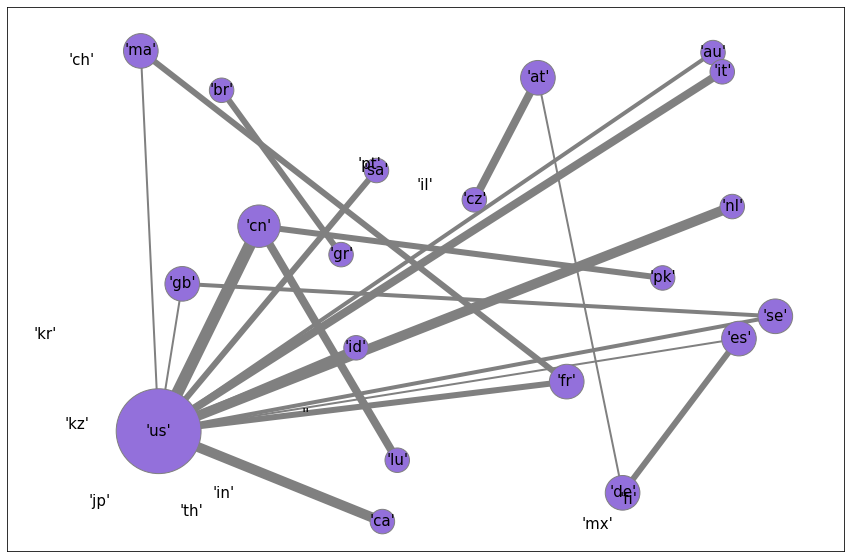

In [40]:
#@title generate country graph
resultsdict= results.to_dict('record')
get_country_graph_by_fields(resultsdict)

In [41]:
#@title country search (filter)
countryquery = 'cn' #type in country to search(filter) (must use a term within above graph):
df_countryfilterresults = results[results['country'].str.contains(countryquery)]
df_countryfilterresults

,qid,docid,docno,score,query,date,field,author,topic,querygen,country,features,rank
9,1,18328,Event-related potentials (ERPs) to gender differences in encoding processing for female facial attractiveness.,4.035849,female concern,2012,,"['Bin Wei', 'Yan Zhang']",[],gender differences in encoding and processing\nwhat is erp mean\nwho determines gender identity,"['cn', 'cn']","[13.541445109121339, 7.409055345377417, 1.0, 1.0, 0.0, 0.0]",3
12,1,28639,Gender network dynamics in prosocial and aggressive behavior of early adolescents.,3.361642,female concern,2019,,"['YuanHsiao', 'Ching-LingCheng', 'Ya-WenChiu']",[],gender networks and prosocial behaviors\ngender dynamics for prosocial behavior\nwhat gender is dominant in the early adolescent prosocial behaviors,"['us', 'cn', 'us']","[13.115893629642809, 7.2494845545971005, 2.0, 1.0, 0.0, 0.0]",23
15,1,12832,"Location information disclosure in location-based social network services: Privacy calculus, benefit structure, and gender differences.",3.719912,female concern,2015,,"['YongqiangSun', 'NanWang', 'Xiao-LiangShen', 'Jacky XiZhang']",['social network'],what is location information disclosure\nwhen identifying location in social media\nwhich type of behavior is based on location-based social sharing,"['cn', 'cn', 'cn']","[12.609154762761275, 6.89896275788171, 1.0, 1.0, 0.0, 0.0]",11
19,1,29227,Social media portrait-editing intentions: Comparisons between Chinese and American female college students.,3.664063,female concern,2021,History & Theory,"['DongdongYang', 'Tai-YeeWu', 'David J.Atkin', 'Diana I.Ríos', 'YuemiaoLiu']","['social media', 'social media users']",what is portrait editing on social media\nwhat is social media portrait editing\nwhat is portrait editing purposes,"['us', 'cn', 'us', 'cn']","[12.444351925331825, 6.808792666451249, 1.0, 1.0, 0.0, 0.0]",15
24,1,15195,How Online Social Network and Wearable Devices Enhance Exercise Well-Being of Chinese Females?,3.397160,female concern,2015,,"['Chen, Hao', 'Lin, Ting-Yu Tony', 'Mu, Qiaochu', 'Rau, Pei-Luen Patrick']",['social network'],does social networking enhance exercise\ncan social media help with exercise\nwhat devices boost exercise,"['cn', 'cn', 'cn', 'cn']","[11.656754052503828, 6.377867002117718, 1.0, 1.0, 0.0, 0.0]",22
40,1,27352,An Empirical Study on User Access Control in Online Social Networks.,2.553939,female concern,2016,AI,"['Minyue Ni', 'Yang Zhang', 'Weili Han', 'Jun Pang']","['online social networks', 'social networks', 'social network', 'machine learning']",why is the user a control?\nhow is access control measured\nuser access control in social media,"['cn', 'lu', 'cn', 'lu']","[10.74479546870647, 5.938918917171319, 2.0, 1.0, 0.0, 0.0]",68
49,1,23299,"Discriminating gender on Chinese microblog: A study of online behaviour, writing style and preferred vocabulary.",2.814451,female concern,2014,"Software & Application, Linguistics and Art studies","['Li Li', 'Maosong Sun', 'Zhiyuan Liu']",['sina weibo'],how gender is discriminated on twitter\nwhat is gender discrimination on twitter\nchinese female bloggers,"['cn', 'cn', 'cn']","[10.199250300006995, 5.5804095755783285, 1.0, 1.0, 0.0, 6.099807078538728]",45
68,1,33570,Characterizing user behaviors in location-based find-and-flirt services: Anonymity and demographics - A WeChat Case Study.,2.609616,female concern,2017,"Software & Application, Graph, Area and Development studies","['Xue, Minhui', 'Yang, Limin', 'Ross, Keith W.', 'Qian, Haifeng']","['social network', 'twitter users']",what is wechat\nwhat is wechat?\nwhat is wechat use for,"['cn', 'cn']","[9.332808998414164, 5.106345581278486, 1.0, 1.0, 0.0, 0.0]",62
74,1,8445,Examining the moderating effect of inconsistent reviews and its gender differences on consumers' online shopping decision.,2.538394,female concern,2014,Networks,"['Kem Z.K.Zhang', 'Christy M.K.Cheung', 'Matthew K.O.Lee']",['social media'],moderating effect of inconsistent reviews\nmoderating effect of inconsistencies\nmoderating effect of